In [13]:
# %%writefile ghost_variables.py

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.exceptions import NotFittedError
from functools import partial 
try:
    from pygam import LinearGAM # Using LinearGAM for simplicity
except ImportError:
    LinearGAM = None # Handle optional dependency
    # print("Warning: Package 'pygam' not found. 'gam' estimator type will not be available.") # Less noisy

from typing import Type, Dict, Any, List, Union, Optional, Tuple
import warnings
import joblib # For parallelization
import inspect # For robust parameter handling

class GhostVariableEstimator:
    """
    Estimates ghost variables E(Z|X_{-j}) for each variable Z_j in a dataset X.
    Supports different regression models for estimating the conditional expectation.
    Based on the concept proposed by Peña & Delicado (2023).

    Args:
        estimator_type (str): Model type ('lm', 'rf', 'gam'). Defaults to 'rf'.
        n_jobs (Optional[int]): Parallel jobs for estimating different ghosts.
                                  Defaults to 1 (serial). Set to -1 to use all cores,
                                  but be aware of potential serialization errors.
        estimator_params: Keyword arguments passed to the underlying regressor.
    """
    SUPPORTED_ESTIMATORS: Dict[str, Optional[Type[BaseEstimator]]] = {
        'lm': LinearRegression,
        'rf': RandomForestRegressor,
        'gam': LinearGAM
    }

    DEFAULT_PARAMS: Dict[str, Dict[str, Any]] = {
        'lm': {'n_jobs': None}, # LM's n_jobs is different, let joblib handle outer parallelism
        'rf': {'n_estimators': 100, 'random_state': 42, 'n_jobs': 1, 'max_depth': 10, 'min_samples_leaf': 5},
        'gam': {'n_splines': 10, 'max_iter': 100, 'tol': 1e-3}
    }

    # ***** CHANGE: Default n_jobs to 1 *****
    def __init__(self, estimator_type: str = 'rf', n_jobs: Optional[int] = 1, **estimator_params):
        estimator_key = estimator_type.lower()
        if estimator_key not in self.SUPPORTED_ESTIMATORS:
            raise ValueError(f"Invalid estimator_type '{estimator_type}'. Choose from {list(k for k,v in self.SUPPORTED_ESTIMATORS.items() if v is not None)}.")
        if self.SUPPORTED_ESTIMATORS[estimator_key] is None:
             # Added print here for clarity if user tries 'gam' without pygam
             print(f"Optional dependency for estimator type '{estimator_key}' not found. Please install it (e.g., pip install pygam).")
             raise ImportError(f"Estimator type '{estimator_key}' requires an optional dependency that is not installed.")

        self.estimator_key: str = estimator_key
        self.estimator_class: Type[BaseEstimator] = self.SUPPORTED_ESTIMATORS[estimator_key]

        merged_params = self.DEFAULT_PARAMS.get(estimator_key, {}).copy()
        merged_params.update(estimator_params)
        self.estimator_params: Dict[str, Any] = merged_params
        self.n_jobs = n_jobs # Store user preference
        self._fitted_estimators: Dict[str, BaseEstimator] = {}

        print(f"Initialized GhostVariableEstimator with {self.estimator_key.upper()} (params: {self.estimator_params}, requested n_jobs={self.n_jobs})")
        if self.n_jobs != 1:
            print("Note: Using n_jobs != 1 may cause serialization errors depending on the environment/estimators.")

    def _get_estimator_instance(self) -> BaseEstimator:
        """Instantiates a new underlying estimator model with configured parameters."""
        sig = inspect.signature(self.estimator_class.__init__)
        valid_keys = {p.name for p in sig.parameters.values() if p.kind == p.POSITIONAL_OR_KEYWORD or p.kind == p.KEYWORD_ONLY}
        if 'self' not in valid_keys and any(p.name == 'self' for p in sig.parameters.values()):
             valid_keys.add('self')
        init_params = {k: v for k, v in self.estimator_params.items() if k in valid_keys}
        try:
             return self.estimator_class(**init_params)
        except TypeError as e:
             warnings.warn(f"Error initializing {self.estimator_key.upper()} with filtered params {init_params}: {e}. Trying default.", UserWarning)
             try:
                 return self.estimator_class()
             except Exception as e_def:
                  raise RuntimeError(f"Failed to initialize {self.estimator_key.upper()} with both provided and default params.") from e_def


    def _estimate_single_ghost_job(self, X_df: pd.DataFrame, target_var_name: str) -> Optional[pd.Series]:
        """
        Internal helper: Estimates E(Z|X_{-j}) for a single target variable Z_j.
        Designed for parallel execution. Returns None on failure.
        """
        current_job_id = f"{target_var_name} (using {self.estimator_key})"
        try:
            if target_var_name not in X_df.columns:
                 warnings.warn(f"[{current_job_id}] Target variable not found in DataFrame.", UserWarning)
                 return None

            if X_df.shape[1] <= 1:
                warnings.warn(f"[{current_job_id}] Cannot estimate ghost with <= 1 feature. Returning original.", UserWarning)
                return X_df[target_var_name].astype(float)

            target_series = X_df[target_var_name]
            feature_df = X_df.drop(columns=[target_var_name])

            if not pd.api.types.is_numeric_dtype(target_series):
                 warnings.warn(f"[{current_job_id}] Target is not numeric. Cannot estimate ghost. Returning original.", UserWarning)
                 return target_series.astype(float) # Attempt conversion

            # Feature preprocessing
            if self.estimator_key in ['lm', 'rf']:
                numeric_features = feature_df.select_dtypes(include=np.number)
                if numeric_features.empty:
                     warnings.warn(f"[{current_job_id}] No numeric features found for {self.estimator_key}. Returning original.", UserWarning)
                     return target_series.astype(float)
                if numeric_features.shape[1] < feature_df.shape[1]:
                     warnings.warn(f"[{current_job_id}] Non-numeric features dropped for {self.estimator_key}.", UserWarning)
                feature_df_processed = numeric_features
            elif self.estimator_key == 'gam':
                 numeric_features = feature_df.select_dtypes(include=np.number)
                 if numeric_features.empty:
                     warnings.warn(f"[{current_job_id}] No numeric features found for GAM. Returning original.", UserWarning)
                     return target_series.astype(float)
                 if numeric_features.shape[1] < feature_df.shape[1]:
                     warnings.warn(f"[{current_job_id}] Non-numeric features dropped for GAM (requires encoding).", UserWarning)
                 feature_df_processed = numeric_features
            else:
                 feature_df_processed = feature_df # Should not happen

            # Basic Imputation (example, consider better strategies)
            if feature_df_processed.isnull().any().any():
                 warnings.warn(f"[{current_job_id}] Features contain NaNs after selection. Applying median imputation.", UserWarning)
                 for col in feature_df_processed.columns:
                     if feature_df_processed[col].isnull().any():
                         median_val = feature_df_processed[col].median()
                         # Use .loc to avoid SettingWithCopyWarning
                         feature_df_processed.loc[:, col] = feature_df_processed[col].fillna(median_val)


            estimator = self._get_estimator_instance()
            estimator.fit(feature_df_processed.values, target_series.values)
            Z_ghost = estimator.predict(feature_df_processed.values)
            # self._fitted_estimators[target_var_name] = estimator # Optional storage

            return pd.Series(Z_ghost.astype(float), index=X_df.index, name=target_var_name)

        except Exception as e:
            warnings.warn(f"[{current_job_id}] Error during estimation: {e}. Returning None.", UserWarning)
            return None


    def estimate_all_ghosts(self, X_data: pd.DataFrame) -> pd.DataFrame:
        """
        Estimates ghost variables E(Z|X_{-j}) for all columns Z_j in the DataFrame.

        Args:
            X_data (pd.DataFrame): Input data (features). Must be pandas DataFrame.

        Returns:
            pd.DataFrame: DataFrame containing estimated ghost variables for successfully
                          processed columns. Columns where estimation failed are omitted.
        """
        if not isinstance(X_data, pd.DataFrame) or X_data.empty:
            raise ValueError("Input must be a non-empty pandas DataFrame.")
        if X_data.isnull().any().any():
             warnings.warn("Input data contains NaNs. Consider imputation before calling estimate_all_ghosts.", UserWarning)

        print(f"\nEstimating all ghost variables using {self.estimator_key.upper()}...")
        target_vars = list(X_data.columns) # Keep original order

        # Use joblib for parallelism, but respect n_jobs=1 for serial execution
        # Set verbosity based on n_jobs; less verbose for serial run.
        verbosity = 5 if self.n_jobs != 1 else 0
        try:
            with joblib.Parallel(n_jobs=self.n_jobs, backend='loky', verbose=verbosity) as parallel:
                 results = parallel(
                     joblib.delayed(self._estimate_single_ghost_job)(X_data.copy(), var_name)
                     for var_name in target_vars
                 )
        except Exception as e:
             # Catch potential top-level joblib errors (like the BrokenProcessPool)
             warnings.warn(f"Joblib parallel execution failed: {e}. Attempting serial execution.", RuntimeWarning)
             results = [self._estimate_single_ghost_job(X_data.copy(), var_name) for var_name in target_vars]


        # Process results
        valid_results_map = {res.name: res for res in results if res is not None}

        if not valid_results_map:
             raise RuntimeError("All ghost variable estimations failed. Check warnings.")

        # Reconstruct DataFrame maintaining original column order for successful estimations
        successful_cols = [col for col in target_vars if col in valid_results_map]
        ghost_df = pd.concat([valid_results_map[col] for col in successful_cols], axis=1)

        failed_cols = set(target_vars) - set(successful_cols)
        if failed_cols:
             warnings.warn(f"Ghost variable estimation failed for: {sorted(list(failed_cols))}. Check previous warnings.", UserWarning)

        print(f"Ghost variable estimation complete. Successfully estimated for {len(successful_cols)} out of {len(target_vars)} variables.")
        return ghost_df #[successful_cols] # Return only successful ones in original relative order

In [36]:
## %%writefile survival_data_generator.py

import pandas as pd
import numpy as np
from typing import Type, Dict, Any, List, Union, Optional, Tuple, Callable
import warnings

try:
    from sksurv.util import Surv # Required for scikit-survival format
    sksurv_available = True
except ImportError:
    Surv = None # Handle optional dependency
    sksurv_available = False
    warnings.warn("Package 'scikit-survival' not found. Data generation will not produce sksurv structured arrays.", ImportWarning)



import pandas as pd
import numpy as np
from typing import List, Dict, Any, Optional, Callable, Union, Tuple
import warnings

# Assume sksurv.util.Surv is available or handled
try:
    from sksurv.util import Surv
    sksurv_available = True
except ImportError:
    class Surv: pass # Dummy
    sksurv_available = False

def generate_uncorrelated_features(n_samples: int, n_features: int, rng: np.random.Generator) -> pd.DataFrame:
    """Generates independent standard normal features."""
    data = rng.normal(0, 1, size=(n_samples, n_features))
    feature_names = [f'X{i+1}' for i in range(n_features)]
    return pd.DataFrame(data, columns=feature_names)

def generate_correlated_features(n_samples: int, n_features: int, rng: np.random.Generator, corr_matrix: np.ndarray) -> pd.DataFrame:
    """Generates multivariate normal features with a specified correlation matrix."""
    if corr_matrix.shape != (n_features, n_features):
        raise ValueError("Correlation matrix dimensions must match n_features.")
    # Use Cholesky decomposition to generate correlated data
    try:
        L = np.linalg.cholesky(corr_matrix)
    except np.linalg.LinAlgError:
         raise ValueError("Correlation matrix is not positive definite!")
    uncorrelated_data = rng.normal(0, 1, size=(n_samples, n_features))
    correlated_data = uncorrelated_data @ L.T # Apply transformation
    feature_names = [f'X{i+1}' for i in range(n_features)]
    return pd.DataFrame(correlated_data, columns=feature_names)

# Define the non-linear function globally too
def nonlinear_predictor_func(df: pd.DataFrame) -> np.ndarray:
    """Example non-linear function f(x)."""
    required_cols = ['X1', 'X2', 'X3']
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"DataFrame missing required columns for nonlinear_predictor_func: {required_cols}")
    score = 1.0 * df['X1'] + np.sin(np.pi * df['X2']) + 0.5 * (df['X3']**2)
    return score.values


import pandas as pd
import numpy as np
from typing import List, Dict, Any, Optional, Callable, Union, Tuple
import warnings

# Assume generate_uncorrelated_features and generate_correlated_features
# are defined globally as before.

# Assume sksurv.util.Surv is available or handled
try:
    from sksurv.util import Surv
    sksurv_available = True
except ImportError:
    class Surv: pass # Dummy
    sksurv_available = False


class SurvivalDataGenerator:
    def __init__(self,
                 n_samples: int = 500,
                 n_features: int = 3,
                 # --- NEW ARGUMENTS ---
                 feature_generation_type: str = 'uncorrelated', # 'uncorrelated' or 'correlated'
                 corr_matrix: Optional[np.ndarray] = None, # Required if type is 'correlated'
                 # --- END NEW ARGUMENTS ---
                 beta_coeffs: Optional[List[float]] = None,
                 nonlinear_func: Optional[Callable[[pd.DataFrame], np.ndarray]] = None,
                 baseline_hazard_lambda: float = 0.01,
                 censoring_dist_lambda: float = 0.002,
                 contamination_prop: float = 0.0,
                 random_state: Optional[int] = None):

        # --- VALIDATION FOR NEW ARGUMENTS ---
        self.feature_generation_type = feature_generation_type.lower()
        if self.feature_generation_type not in ['uncorrelated', 'correlated']:
            raise ValueError("feature_generation_type must be 'uncorrelated' or 'correlated'")
        if self.feature_generation_type == 'correlated' and corr_matrix is None:
            raise ValueError("corr_matrix must be provided when feature_generation_type is 'correlated'")
        if self.feature_generation_type == 'correlated' and corr_matrix.shape != (n_features, n_features):
             raise ValueError(f"corr_matrix shape {corr_matrix.shape} does not match n_features {n_features}")
        self.corr_matrix = corr_matrix
        # --- END VALIDATION ---

        if beta_coeffs is not None and len(beta_coeffs) != n_features:
             raise ValueError("Length of beta_coeffs must match n_features.")
        # ... (rest of beta vs nonlinear func logic remains same) ...
        elif beta_coeffs is None and nonlinear_func is None:
             warnings.warn("Neither beta_coeffs nor nonlinear_func provided. Using f(X) = sum(X_i).", UserWarning)
             self.nonlinear_func = lambda x_df: x_df.sum(axis=1).values # Default simple sum
             self.beta_coeffs = None
        elif beta_coeffs is not None and nonlinear_func is not None:
             warnings.warn("Both beta_coeffs and nonlinear_func provided. Using nonlinear_func.", UserWarning)
             self.beta_coeffs = None
             self.nonlinear_func = nonlinear_func
        elif beta_coeffs is not None:
             self.beta_coeffs = np.array(beta_coeffs)
             self.nonlinear_func = None
        else: # nonlinear_func is provided, beta_coeffs is None
             self.beta_coeffs = None
             self.nonlinear_func = nonlinear_func


        self.n_samples = n_samples
        self.n_features = n_features
        self.feature_names = [f'X{i+1}' for i in range(n_features)]
        # self.feature_generation_func = feature_generation_func # REMOVED
        self.beta_coeffs = np.array(beta_coeffs) if beta_coeffs is not None else None
        self.nonlinear_func = nonlinear_func
        self.baseline_hazard_lambda = baseline_hazard_lambda
        self.censoring_dist_lambda = censoring_dist_lambda
        self.contamination_prop = contamination_prop
        self.rng = np.random.default_rng(random_state)

        print(f"Initialized SurvivalDataGenerator (n={n_samples}, p={n_features}, type='{self.feature_generation_type}', alpha={contamination_prop})")


    def _generate_features(self) -> pd.DataFrame:
        """ Generates features based on the specified type. """
        try:
            if self.feature_generation_type == 'uncorrelated':
                # Ensure generate_uncorrelated_features is defined globally
                features_df = generate_uncorrelated_features(self.n_samples, self.n_features, self.rng)
            elif self.feature_generation_type == 'correlated':
                # Ensure generate_correlated_features is defined globally
                if self.corr_matrix is None: # Should be caught by init, but double-check
                    raise ValueError("Correlation matrix is missing for 'correlated' type.")
                features_df = generate_correlated_features(self.n_samples, self.n_features, self.rng, self.corr_matrix)
            else:
                # Should not happen due to init check
                raise ValueError(f"Unknown feature_generation_type: {self.feature_generation_type}")

        except NameError as e:
             raise NameError(f"Helper function for '{self.feature_generation_type}' features not defined globally: {e}")
        except Exception as e:
             raise RuntimeError(f"Error during feature generation for type '{self.feature_generation_type}'.") from e

        # Ensure correct column names and order AFTER generation
        if features_df.shape != (self.n_samples, self.n_features):
             raise ValueError(f"Feature generation produced shape {features_df.shape}, expected ({self.n_samples}, {self.n_features}).")
        features_df.columns = self.feature_names
        return features_df[self.feature_names] # Return in defined order

    # --- Methods _calculate_predictor_score and generate remain unchanged ---
    # (Make sure they are still present in your class definition)
    def _calculate_predictor_score(self, X: pd.DataFrame) -> np.ndarray:
        """ Calculates the linear or non-linear predictor score f(X) or beta'X. """
        if self.nonlinear_func:
            try:
                 score = self.nonlinear_func(X)
                 if not isinstance(score, np.ndarray) or score.ndim != 1 or score.shape[0] != X.shape[0]:
                      raise ValueError(f"nonlinear_func must return a 1D numpy array of length {X.shape[0]}")
                 return score
            except Exception as e:
                 raise ValueError("Error executing nonlinear_func.") from e
        elif self.beta_coeffs is not None:
             if not all(col in X.columns for col in self.feature_names):
                  raise ValueError("Input DataFrame X is missing expected feature columns for beta calculation.")
             return X[self.feature_names].values @ self.beta_coeffs
        else:
             warnings.warn("Neither beta_coeffs nor nonlinear_func provided. Using f(X) = sum(X_i).", UserWarning)
             return X[self.feature_names].sum(axis=1).values

    def generate(self, return_sksurv_array: bool = True) -> Union[Tuple[pd.DataFrame, np.ndarray], Tuple[pd.DataFrame, pd.Series, pd.Series]]:
        """ Generates the survival dataset. """
        if return_sksurv_array and not sksurv_available:
             warnings.warn("scikit-survival not found. Returning time and event as separate Series.", ImportWarning)
             return_sksurv_array = False

        # print("Generating survival data...") # Reduce verbosity inside loop
        X = self._generate_features()
        predictor_score = self._calculate_predictor_score(X)

        # Generate latent event times
        rate = self.baseline_hazard_lambda * np.exp(predictor_score)
        rate = np.maximum(rate, 1e-12)
        scale = 1.0 / rate
        T_latent = self.rng.exponential(scale=scale, size=self.n_samples)

        # Contamination
        # ... (Contamination logic remains the same as your previous working version) ...
        outlier_indices = np.array([], dtype=int)
        if self.contamination_prop > 0:
            n_outliers = int(np.round(self.contamination_prop * self.n_samples))
            if n_outliers > 0 and n_outliers < self.n_samples:
                outlier_indices = self.rng.choice(self.n_samples, n_outliers, replace=False)
                p01 = np.percentile(T_latent, 1)
                p99 = np.percentile(T_latent, 99)
                max_T = np.max(T_latent)
                outlier_times_early = self.rng.uniform(0, max(p01 * 0.9, 1e-6), n_outliers)
                late_lower_bound = p99
                late_upper_bound = max(p99 * 1.01, max_T * 1.1)
                if late_upper_bound <= late_lower_bound:
                    late_upper_bound = late_lower_bound + 1e-6 * (late_lower_bound + 1.0)
                outlier_times_late = self.rng.uniform(late_lower_bound, late_upper_bound, n_outliers)
                u_i = self.rng.binomial(1, 0.5, n_outliers)
                T_latent[outlier_indices] = np.where(u_i == 1, outlier_times_early, outlier_times_late)
                # print(f"Introduced {n_outliers} contaminated time points (early/late).") # Reduce verbosity
            # ... (warning for contamination_prop >= 1 remains same) ...

        # Generate censoring times
        if self.censoring_dist_lambda <= 0:
             T_cens = np.full(self.n_samples, np.inf)
             # print("censoring_dist_lambda <= 0 implies effectively no censoring.")
        else:
             T_cens = self.rng.exponential(scale=1.0 / self.censoring_dist_lambda, size=self.n_samples)

        # Observed time and event status
        E_bool = (T_latent <= T_cens)
        T_obs = np.minimum(T_latent, T_cens)

        # Handle potential NaNs or Infs
        valid_idx = np.isfinite(T_obs) & np.isfinite(predictor_score) & ~np.isnan(T_obs) & ~np.isnan(predictor_score)
        if not np.all(valid_idx):
             n_removed = self.n_samples - np.sum(valid_idx)
             warnings.warn(f"Removed {n_removed} samples due to non-finite time or predictor score values.", UserWarning)
             X = X.loc[valid_idx].reset_index(drop=True)
             T_obs = T_obs[valid_idx]
             E_bool = E_bool[valid_idx]
             if X.empty:
                  raise ValueError("All samples removed due to invalid values during generation.")

        actual_censoring_prop = 1.0 - E_bool.mean()
        # print(f"Data generation complete. Final n={X.shape[0]}. Actual censoring: {actual_censoring_prop:.2f}") # Reduce verbosity

        if return_sksurv_array:
            y_structured = Surv.from_arrays(event=E_bool, time=T_obs)
            return X, y_structured
        else:
            return X, pd.Series(T_obs, name='time'), pd.Series(E_bool, name='event')



In [15]:
# %%writefile nonlinear_survival_model.py

import pandas as pd
import numpy as np
from sklearn.exceptions import NotFittedError
from typing import Type, Dict, Any, Optional
import warnings

# --- Attempt to import scikit-survival ---
try:
    from sksurv.ensemble import RandomSurvivalForest
    from sksurv.util import Surv # Utility for structured array format
    # Future: Add other models like GradientBoostingSurvivalAnalysis if needed
    sksurv_available = True
except ImportError:
    # Define dummy classes if sksurv not available, so the rest of the code loads
    class RandomSurvivalForest: pass
    class Surv: pass
    sksurv_available = False
    warnings.warn("Package 'scikit-survival' not found. NonLinearSurvivalModel class will not function properly.", ImportWarning)
# --- End Import Handling ---

class NonLinearSurvivalModel:
    """
    A wrapper class for non-linear survival models from scikit-survival.
    Currently implements Random Survival Forest (RSF).

    Args:
        model_type (str): The type of survival model. Currently only 'rsf' supported.
        model_params: Keyword arguments passed to the underlying scikit-survival
                      model constructor. Defaults are provided for RSF.
    """
    SUPPORTED_MODELS: Dict[str, Optional[Type[Any]]] = {
        'rsf': RandomSurvivalForest if sksurv_available else None,
    }

    DEFAULT_PARAMS: Dict[str, Dict[str, Any]] = {
        'rsf': {'n_estimators': 100, 'random_state': 42, 'n_jobs': -1,
                'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': None}
    }

    def __init__(self, model_type: str = 'rsf', **model_params):
        if not sksurv_available:
            raise ImportError("scikit-survival is required for NonLinearSurvivalModel but is not installed.")

        model_key = model_type.lower()
        model_class_ref = self.SUPPORTED_MODELS.get(model_key)

        if model_class_ref is None:
            raise ValueError(f"Unsupported model_type '{model_type}'. Choose from {list(self.SUPPORTED_MODELS.keys())}.")

        self.model_type: str = model_key
        self.model_class: Type[Any] = model_class_ref

        # Combine default params with user-provided params
        merged_params = self.DEFAULT_PARAMS.get(model_key, {}).copy()
        merged_params.update(model_params)
        self.model_params: Dict[str, Any] = merged_params

        # Instantiate the underlying model
        try:
            self.model = self.model_class(**self.model_params)
        except Exception as e:
            raise RuntimeError(f"Failed to initialize {self.model_type.upper()} with params {self.model_params}") from e

        self._is_fitted: bool = False
        self.feature_names_in_: Optional[list] = None # Store feature names during fit

        print(f"Initialized NonLinearSurvivalModel with {self.model_type.upper()} (params: {self.model_params})")

    def fit(self, X: pd.DataFrame, y_structured: np.ndarray):
        """
        Fits the survival model to the training data.

        Args:
            X (pd.DataFrame): DataFrame of features for training.
            y_structured (np.ndarray): Structured array containing 'event' (bool)
                                       and 'time' (float) fields, typically created
                                       using sksurv.util.Surv.from_dataframe() or .from_arrays().
        """
        if not isinstance(X, pd.DataFrame):
             raise ValueError("X must be a pandas DataFrame.")
        if not sksurv_available or Surv is None: # Double check just in case
             raise ImportError("scikit-survival required for fitting.")
        # Basic check for structured array type
        if not isinstance(y_structured, np.ndarray) or not all(name in y_structured.dtype.names for name in ['event', 'time']):
             raise ValueError("y_structured must be a numpy structured array with 'event' and 'time' fields (from sksurv.util.Surv).")

        print(f"Fitting {self.model_type.upper()}...")
        try:
            # Store feature names to ensure consistency during prediction
            self.feature_names_in_ = list(X.columns)
            # Ensure X contains only numeric data before passing to sksurv model
            X_numeric = X.select_dtypes(include=np.number)
            if X_numeric.shape[1] < X.shape[1]:
                 dropped_cols = list(set(X.columns) - set(X_numeric.columns))
                 warnings.warn(f"Non-numeric columns dropped from X before fitting: {dropped_cols}", UserWarning)
            if X_numeric.isnull().any().any():
                 warnings.warn("X contains NaNs after numeric selection. Consider imputation. Fitting may fail.", UserWarning)
                 # Basic imputation (median) - replace with more robust strategy if needed
                 for col in X_numeric.columns[X_numeric.isnull().any()]:
                      median_val = X_numeric[col].median()
                      X_numeric[col] = X_numeric[col].fillna(median_val)

            if X_numeric.empty:
                raise ValueError("No numeric features remaining in X after preprocessing.")

            self.model.fit(X_numeric, y_structured)
            self._is_fitted = True
            print("Fitting complete.")
        except Exception as e:
            self._is_fitted = False # Ensure state reflects failure
            raise RuntimeError(f"Failed to fit {self.model_type.upper()} model.") from e

        return self

    def predict_risk_score(self, X: pd.DataFrame) -> np.ndarray:
        """
        Predicts the risk score f(x) for new data.
        For RSF, higher scores indicate higher risk (closer to log-hazard).

        Args:
            X (pd.DataFrame): DataFrame of features for prediction.

        Returns:
            np.ndarray: Array of predicted risk scores.
        """
        if not self._is_fitted:
            raise NotFittedError("This NonLinearSurvivalModel instance is not fitted yet. Call 'fit' first.")
        if not isinstance(X, pd.DataFrame):
             raise ValueError("X must be a pandas DataFrame.")
        if not sksurv_available: # Double check
             raise ImportError("scikit-survival required for prediction.")

        # Ensure input features match training features order and presence
        if self.feature_names_in_ is None:
             raise NotFittedError("Model has been fitted but feature names were not stored.")
        if list(X.columns) != self.feature_names_in_:
             warnings.warn("Input features mismatch fitted features order/presence. Reordering/selecting columns.", UserWarning)
             try:
                 # Select and reorder columns to match training
                 X = X[self.feature_names_in_]
             except KeyError as e:
                 missing_cols = list(set(self.feature_names_in_) - set(X.columns))
                 raise ValueError(f"Input data missing columns used during fitting: {missing_cols}") from e

        # Ensure X contains only numeric data before passing to sksurv model
        X_numeric = X.select_dtypes(include=np.number)
        if X_numeric.shape[1] < X.shape[1]:
                 dropped_cols = list(set(X.columns) - set(X_numeric.columns))
                 warnings.warn(f"Non-numeric columns dropped from X before prediction: {dropped_cols}", UserWarning)
        if X_numeric.isnull().any().any():
             warnings.warn("X contains NaNs after numeric selection. Consider imputation. Prediction may fail.", UserWarning)
             # Basic imputation (median)
             for col in X_numeric.columns[X_numeric.isnull().any()]:
                 median_val = X_numeric[col].median()
                 X_numeric[col] = X_numeric[col].fillna(median_val)

        if X_numeric.shape[1] != len(self.feature_names_in_):
            # Check if only non-numeric columns existed, leading to empty df
            if X_numeric.empty and not any(X[f].dtype == np.number for f in self.feature_names_in_):
                 raise ValueError("Model was fitted on features, but input X has no numeric features corresponding to them.")
            # Or if numeric selection failed for other reasons
            raise ValueError(f"Mismatch in number of numeric features after preprocessing. Expected {len(self.feature_names_in_)}, got {X_numeric.shape[1]}.")


        try:
            # predict() for RSF returns risk scores directly
            risk_scores = self.model.predict(X_numeric)
            return risk_scores
        except Exception as e:
            raise RuntimeError(f"Failed to predict with {self.model_type.upper()} model.") from e

    @property
    def is_fitted(self) -> bool:
        return self._is_fitted

# --- Example Usage (if run directly) ---
if __name__ == '__main__':
    # Assuming GhostVariableEstimator and SurvivalDataGenerator classes are defined above or imported

    if not sksurv_available:
        print("scikit-survival not installed. Skipping NonLinearSurvivalModel example.")
    else:
        print("\n--- Testing NonLinearSurvivalModel ---")
        # Generate some non-linear data using the corrected generator
        try:
            generator = SurvivalDataGenerator(
                n_samples=300, n_features=3,
                nonlinear_func=lambda df: 0.5 * df['X1'] * df['X2'] + np.sin(df['X3'] * np.pi),
                censoring_dist_lambda=0.02,
                random_state=789
            )
            X_train, y_train_sksurv = generator.generate(return_sksurv_array=True)
            X_test, y_test_sksurv = generator.generate(return_sksurv_array=True) # Generate separate test set

            # Initialize and fit the RSF model
            nl_model = NonLinearSurvivalModel(model_type='rsf', n_estimators=50, min_samples_leaf=10, random_state=789)
            nl_model.fit(X_train, y_train_sksurv)

            # Predict risk scores on test data
            if nl_model.is_fitted:
                risk_scores_test = nl_model.predict_risk_score(X_test)
                print("\nPredicted Risk Scores (f(x)) on Test Set (Head):")
                print(risk_scores_test[:5])

                # Check model performance (optional - using concordance index)
                try:
                    from sksurv.metrics import concordance_index_censored
                    # Ensure y_test_sksurv has boolean 'event' field
                    event_indicator = y_test_sksurv['event'].astype(bool)
                    time_indicator = y_test_sksurv['time']
                    c_index = concordance_index_censored(event_indicator, time_indicator, risk_scores_test)
                    print(f"\nTest Set Concordance Index: {c_index[0]:.4f}")
                except ImportError:
                    print("\nCannot calculate Concordance Index - sksurv.metrics not found?")
                except Exception as e:
                    print(f"\nError calculating Concordance Index: {e}")

        except ImportError:
            print("Skipping example because scikit-survival is not installed.")
        except Exception as e:
            print(f"An error occurred during the example execution: {e}")


--- Testing NonLinearSurvivalModel ---
Initialized SurvivalDataGenerator (n=300, p=3, alpha=0.0)
Generating survival data...
An error occurred during the example execution: name 'generate_uncorrelated_features' is not defined


C:\Users\sanisaza\AppData\Local\Temp\ipykernel_16760\3003328365.py:62: UserWarning: No feature_generation_func provided. Using default (uncorrelated standard normal).
  warnings.warn("No feature_generation_func provided. Using default (uncorrelated standard normal).", UserWarning)


In [16]:
import pandas as pd
import numpy as np
from sklearn.exceptions import NotFittedError
from typing import Type, Dict, Any, Optional, Tuple
import warnings

# Assuming NonLinearSurvivalModel and GhostVariableEstimator classes are defined elsewhere

class GhostCoxInterpreter:
    """
    Interprets a fitted non-linear survival model using the Ghost Variables methodology.

    Calculates variable relevance (RV_gh) based on the change in the model's
    predicted risk score when a variable is replaced by its ghost.
    Optionally calculates the Relevance Matrix V.

    Args:
        survival_model (NonLinearSurvivalModel): A fitted instance of the survival model wrapper.
        ghost_estimator (GhostVariableEstimator): An initialized instance for estimating ghost variables.
    """
    def __init__(self,
                 survival_model: 'NonLinearSurvivalModel',
                 ghost_estimator: 'GhostVariableEstimator'):

        if not hasattr(survival_model, 'predict_risk_score') or not callable(survival_model.predict_risk_score):
             raise TypeError("survival_model must have a callable 'predict_risk_score' method.")
        if not hasattr(survival_model, 'is_fitted') or not survival_model.is_fitted:
             raise NotFittedError("The provided survival_model must be fitted first.")
        if not isinstance(ghost_estimator, GhostVariableEstimator):
             raise TypeError("ghost_estimator must be an instance of GhostVariableEstimator.")

        self.survival_model = survival_model
        self.ghost_estimator = ghost_estimator
        print("Initialized GhostCoxInterpreter.")


    def calculate_relevance(self, X_test: pd.DataFrame, calculate_relevance_matrix: bool = True) -> Tuple[pd.DataFrame, Optional[pd.DataFrame]]:
     """
     Calculates ghost variable relevance RV_gh for each variable in X_test.

     Args:
          X_test (pd.DataFrame): The test dataset (features only).
          calculate_relevance_matrix (bool): If True, also calculates and returns the
                                             Relevance Matrix V. Defaults to True.

     Returns:
          Tuple[pd.DataFrame, Optional[pd.DataFrame]]:
               - relevance_df: DataFrame containing relevance scores (RV_gh_numerator, RV_gh)
                              and ranks for each variable.
               - V_df: DataFrame representing the normalized Relevance Matrix V (or None if
                         calculate_relevance_matrix is False).
     """
     if not isinstance(X_test, pd.DataFrame) or X_test.empty:
          raise ValueError("X_test must be a non-empty pandas DataFrame.")
     if not self.survival_model.is_fitted:
          raise NotFittedError("The survival model within the interpreter is not fitted.")

     print("\nCalculating Ghost Variable Relevance...")
     n_samples, n_features_orig = X_test.shape
     feature_names_orig = list(X_test.columns)

     # 1. Estimate all ghost variables for the test set
     X_ghost_test = self.ghost_estimator.estimate_all_ghosts(X_test)

     # Determine successfully ghosted features
     valid_feature_names = list(X_ghost_test.columns)
     if not valid_feature_names:
          raise RuntimeError("Ghost estimation failed for all variables.")
     if len(valid_feature_names) < n_features_orig:
          missing_ghosts = set(feature_names_orig) - set(valid_feature_names)
          warnings.warn(f"Could not estimate ghosts for: {missing_ghosts}. Excluding these from relevance calculation.", UserWarning)

     # Use only the features for which ghosts were successfully estimated
     X_test_filtered = X_test[valid_feature_names]
     n_samples, n_features = X_test_filtered.shape # Update dimensions

     # 2. Get predictions from the survival model on original (filtered) test data
     try:
          f_X_test = self.survival_model.predict_risk_score(X_test_filtered)
          if f_X_test.ndim != 1 or len(f_X_test) != n_samples:
               raise ValueError(f"predict_risk_score returned unexpected shape {f_X_test.shape}")
     except Exception as e:
          raise RuntimeError("Failed to get predictions from the survival model on filtered X_test.") from e

     # --- NORMALIZATION FACTOR CALCULATION ---
     # Calculate the variance of the original predictions on the test set
     var_f_test = np.var(f_X_test)
     # Handle potential zero variance (e.g., if predictions are constant)
     if var_f_test < np.finfo(float).eps: # Use machine epsilon for safe comparison
          warnings.warn("Variance of predicted risk scores on test set is near zero. RV_gh cannot be calculated (will be NaN).", UserWarning)
          var_f_test = np.nan # Set to NaN to propagate the issue clearly
     else:
          print(f"Normalization factor Var(f_test): {var_f_test:.4f}") # Added print
     # -----------------------------------------

     relevance_results = {}
     A_matrix = np.zeros((n_samples, n_features)) # Size based on valid features

     # 3. Loop through each VALID variable to calculate relevance
     for j, var_name in enumerate(valid_feature_names):
          # print(f"... calculating relevance for {var_name} ({j+1}/{n_features})") # Reduced verbosity
          X_test_j_ghost = X_test_filtered.copy()
          try:
               # Use .loc for safer assignment and handle potential type issues
               X_test_j_ghost.loc[:, var_name] = X_ghost_test[var_name].astype(X_test_filtered[var_name].dtype, errors='ignore')
          except Exception:
               X_test_j_ghost.loc[:, var_name] = X_ghost_test[var_name] # Assign directly if casting fails

          # Get predictions with the ghost variable substituted
          try:
               f_X_test_j_ghost = self.survival_model.predict_risk_score(X_test_j_ghost)
               if f_X_test_j_ghost.shape != f_X_test.shape:
                    raise ValueError(f"Prediction shape mismatch for ghost '{var_name}': {f_X_test_j_ghost.shape} vs {f_X_test.shape}")
          except Exception as e:
               warnings.warn(f"Could not get prediction for ghost '{var_name}': {e}. Setting relevance to NaN.", UserWarning)
               relevance_results[var_name] = {'RV_gh_numerator': np.nan, 'RV_gh': np.nan} # Store NaN for both
               A_matrix[:, j] = np.nan # Mark column as invalid
               continue

          # Calculate change and store
          prediction_change = f_X_test - f_X_test_j_ghost
          A_matrix[:, j] = prediction_change
          mean_sq_change = np.mean(prediction_change**2)

          # --- APPLY NORMALIZATION ---
          normalized_relevance = mean_sq_change / var_f_test if not np.isnan(var_f_test) else np.nan
          # --------------------------

          relevance_results[var_name] = {
               'RV_gh_numerator': mean_sq_change,
               'RV_gh': normalized_relevance # Store the normalized value
          }

     # Create DataFrame from results
     relevance_df = pd.DataFrame.from_dict(relevance_results, orient='index')

     # Filter out any NaNs that might have occurred
     nan_features = relevance_df[relevance_df['RV_gh'].isna()].index.tolist()
     if nan_features:
          warnings.warn(f"Relevance calculation resulted in NaN for: {nan_features}. Excluding them from Rank and V Matrix.", UserWarning)
          relevance_df_valid = relevance_df.dropna(subset=['RV_gh'])
          # Filter corresponding columns from A_matrix if calculating V
          valid_indices_for_V = [j for j, name in enumerate(valid_feature_names) if name in relevance_df_valid.index]
          A_matrix_valid = A_matrix[:, valid_indices_for_V]
          valid_feature_names_for_V = relevance_df_valid.index.tolist() # Update list for V
     else:
          relevance_df_valid = relevance_df # Use the full df if no NaNs
          A_matrix_valid = A_matrix
          valid_feature_names_for_V = valid_feature_names

     if relevance_df_valid.empty:
          # Add Rank column even if empty to avoid errors later, though it will be empty
          relevance_df['Rank'] = np.nan
          warnings.warn("Relevance calculation failed or resulted in NaN for all variables. Cannot rank or calculate V matrix.", RuntimeWarning)
     else:
          # Calculate Rank based on the normalized RV_gh for valid features
          relevance_df['Rank'] = relevance_df_valid['RV_gh'].rank(ascending=False).astype(int)
          # Add NaN ranks for features that had NaN relevance
          relevance_df['Rank'] = relevance_df['Rank'].reindex(relevance_df.index)


     # 4. Calculate Relevance Matrix V (optional)
     V_df = None
     if calculate_relevance_matrix:
          if not valid_feature_names_for_V: # Check if any valid features remain for V
               warnings.warn("No valid features remaining to calculate Relevance Matrix V.", UserWarning)
          elif np.isnan(var_f_test):
               warnings.warn("Cannot calculate Relevance Matrix V because normalization factor (Var(f_test)) is NaN.", UserWarning)
          else:
               print("... calculating Relevance Matrix V")
               # --- APPLY NORMALIZATION TO V ---
               V_matrix = (1.0 / n_samples) * (A_matrix_valid.T @ A_matrix_valid) / var_f_test
               # --------------------------------
               V_df = pd.DataFrame(V_matrix, index=valid_feature_names_for_V, columns=valid_feature_names_for_V)

     print("Relevance calculation complete.")
     # Return the potentially NaN-containing relevance_df and the potentially None V_df
     return relevance_df.sort_values('Rank', na_position='last'), V_df



In [34]:
# %%writefile experiment_runner.py # Use if in a notebook

import pandas as pd
import numpy as np
from time import time
from typing import List, Dict, Any, Optional, Callable, Tuple
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split # Simple train/test split
import inspect # To check constructor args

# Assuming these classes are defined in other files or above
# from survival_data_generator import SurvivalDataGenerator
# from ghost_variables import GhostVariableEstimator
# from nonlinear_survival_model import NonLinearSurvivalModel
# from ghost_cox_interpreter import GhostCoxInterpreter

try:
    from sksurv.metrics import concordance_index_censored
    from sksurv.util import Surv
    sksurv_available = True
except ImportError:
    concordance_index_censored = None
    Surv = None
    sksurv_available = False
    warnings.warn("scikit-survival not found. C-index calculation and plotting might fail.", ImportWarning)

class ExperimentRunner:
    """
    Runs simulation experiments to evaluate the GhostCox interpretability method.

    Handles data generation, model fitting, ghost estimation, relevance calculation,
    performance evaluation (C-index), and basic result aggregation/plotting.

    Args:
        scenarios (List[Dict[str, Any]]): A list of scenario configurations.
                                          Each dict should define keys like 'name',
                                          'data_params', 'model_params', 'ghost_params'.
        n_replicates (int): Number of times to run each scenario. Defaults to 10.
        test_size (float): Proportion of data to use for the test set. Defaults to 0.3.
        random_state_base (Optional[int]): Base seed for reproducibility. Each replicate
                                           will use random_state_base + replicate_index.
    """
    def __init__(self,
                 scenarios: List[Dict[str, Any]],
                 n_replicates: int = 10,
                 test_size: float = 0.3,
                 random_state_base: Optional[int] = 42):

        if not sksurv_available:
            raise ImportError("scikit-survival is required for ExperimentRunner.")

        self.scenarios = scenarios
        self.n_replicates = n_replicates
        self.test_size = test_size
        self.random_state_base = random_state_base
        self.results = [] # List to store results from each run
        self._summary_df = None # Cache for summary results
        print(f"Initialized ExperimentRunner with {len(scenarios)} scenarios and {n_replicates} replicates.")

    def _run_single_replication(self, scenario_config: Dict[str, Any], replicate_id: int) -> Optional[Dict[str, Any]]:
        """ Executes one full replication for a given scenario. """
        scenario_name = scenario_config.get('name', f'Scenario_{replicate_id}')
        run_seed = None
        # --- *** CORRECTED SYNTAX HERE *** ---
        if self.random_state_base is not None:
             # Ensure different seed for each replicate/scenario combo
             # Use a formula that depends on both scenario index and replicate id
             scenario_index = self.scenarios.index(scenario_config) if scenario_config in self.scenarios else 0
             run_seed = self.random_state_base + (scenario_index * self.n_replicates) + replicate_id
        # --- *** END CORRECTION *** ---

        print(f"\n--- Running: {scenario_name}, Replicate: {replicate_id+1}/{self.n_replicates} (Seed: {run_seed}) ---")
        start_time = time()

        # --- Make sure class definitions are available ---
        # Dynamically check if they exist in the global scope or raise error
        required_classes = ['SurvivalDataGenerator', 'NonLinearSurvivalModel', 'GhostVariableEstimator', 'GhostCoxInterpreter']
        for cls_name in required_classes:
            if cls_name not in globals() and cls_name not in locals():
                 # A simple check; might need more robust import logic depending on file structure
                 raise NameError(f"Class '{cls_name}' is not defined. Ensure it's imported or defined before running.")

        try:
            # 1. Generate Data
            data_params = scenario_config.get('data_params', {}).copy()
            # Pass run_seed to generator if it accepts random_state
            if 'random_state' in inspect.signature(SurvivalDataGenerator.__init__).parameters:
                 data_params['random_state'] = run_seed
            generator = SurvivalDataGenerator(**data_params)
            X, y_sksurv = generator.generate(return_sksurv_array=True)

            min_events_required = 5
            if y_sksurv['event'].sum() < min_events_required:
                 warnings.warn(f"[{scenario_name} Rep {replicate_id+1}] Insufficient events ({y_sksurv['event'].sum()}) generated. Skipping replication.", UserWarning)
                 return None

            # 2. Split Data
            X_train, X_test, y_train, y_test = train_test_split(
                X, y_sksurv, test_size=self.test_size, random_state=run_seed, stratify=y_sksurv['event'] if y_sksurv['event'].sum() > 1 else None # Stratify if possible
            )
            if X_train.empty or X_test.empty or y_test['event'].sum() < 1: # Check test set events
                 warnings.warn(f"[{scenario_name} Rep {replicate_id+1}] Train/test split resulted in empty data or no events in test set. Skipping.", UserWarning)
                 return None

            # 3. Fit Survival Model
            model_params = scenario_config.get('model_params', {}).copy()
            if 'random_state' in inspect.signature(NonLinearSurvivalModel.__init__).parameters:
                 model_params['random_state'] = run_seed
            survival_model = NonLinearSurvivalModel(**model_params)
            survival_model.fit(X_train, y_train)

            # 4. Calculate C-Index on Test Set
            risk_scores_test = survival_model.predict_risk_score(X_test)
            c_index_result = concordance_index_censored(
                y_test['event'].astype(bool), y_test['time'], risk_scores_test
            )
            c_index = c_index_result[0] if c_index_result else np.nan

            # 5. Initialize Ghost Estimator
            ghost_params = scenario_config.get('ghost_params', {}).copy()
            if 'random_state' in inspect.signature(GhostVariableEstimator.__init__).parameters:
                  ghost_params['random_state'] = run_seed
            ghost_estimator = GhostVariableEstimator(**ghost_params)

            # 6. Run Interpreter
            interpreter_params = scenario_config.get('interpreter_params', {}).copy()
            interpreter = GhostCoxInterpreter(survival_model=survival_model, ghost_estimator=ghost_estimator)
            relevance_df, V_matrix_df = interpreter.calculate_relevance(
                X_test,
                calculate_relevance_matrix=interpreter_params.get('calculate_relevance_matrix', True)
            )

            # 7. Store results
            run_duration = time() - start_time
            result = {
                'scenario_name': scenario_name,
                'replicate_id': replicate_id,
                'random_seed': run_seed,
                'c_index': c_index,
                'relevance_df': relevance_df,
                'V_matrix_df': V_matrix_df,
                'duration_sec': run_duration,
                'n_features': X.shape[1],
                'n_train': X_train.shape[0],
                'n_test': X_test.shape[0],
                'ghost_estimator_type': ghost_estimator.estimator_key,
                'survival_model_type': survival_model.model_type,
                'error': None # Indicate success
            }
            print(f"--- Completed: {scenario_name}, Replicate: {replicate_id+1} (C-Index: {c_index:.4f}, Time: {run_duration:.2f}s) ---")
            return result

        except Exception as e:
            print(f"--- FAILED: {scenario_name}, Replicate: {replicate_id+1} ---")
            import traceback
            traceback.print_exc()
            # Attempt to retrieve params even on failure
            ghost_est_type = scenario_config.get('ghost_params', {}).get('estimator_type', 'N/A')
            surv_model_type = scenario_config.get('model_params', {}).get('model_type', 'N/A')
            return {
                'scenario_name': scenario_name,
                'replicate_id': replicate_id,
                'random_seed': run_seed,
                'error': f"{type(e).__name__}: {e}", # More informative error
                'duration_sec': time() - start_time,
                'c_index': np.nan,
                'relevance_df': None,
                'V_matrix_df': None,
                 'ghost_estimator_type': ghost_est_type,
                 'survival_model_type': surv_model_type,
            }


    def run_experiment(self):
        """ Runs all replicates for all defined scenarios. """
        print(f"\n===== Starting Experiment ({len(self.scenarios)} scenarios, {self.n_replicates} replicates each) =====")
        self.results = [] # Clear previous results
        self._summary_df = None # Clear cached summary
        total_start_time = time()

        for i, scenario in enumerate(self.scenarios):
             print(f"\n===== Running Scenario {i+1}/{len(self.scenarios)}: {scenario.get('name', 'Unnamed')} =====")
             for rep in range(self.n_replicates):
                  result = self._run_single_replication(scenario, rep)
                  if result:
                       self.results.append(result)

        total_duration = time() - total_start_time
        print(f"\n===== Experiment Finished (Total Time: {total_duration:.2f}s) =====")
        # Generate and store summary DataFrame
        self._summary_df = self._generate_results_summary()
        return self._summary_df


    def get_results_summary(self) -> Optional[pd.DataFrame]:
         """ Returns the generated summary DataFrame (or generates it if needed). """
         if hasattr(self, '_summary_df') and self._summary_df is not None:
             return self._summary_df
         elif self.results:
             self._summary_df = self._generate_results_summary()
             return self._summary_df
         else:
             print("No results collected yet. Run experiment first.")
             return None


    def _generate_results_summary(self) -> Optional[pd.DataFrame]:
        """ Creates a summary DataFrame from the collected results (long format). """
        if not self.results:
            return None

        summary_data = []
        # Get a set of all variables encountered across successful runs
        all_vars = set()
        for res in self.results:
            if res.get('relevance_df') is not None and isinstance(res['relevance_df'], pd.DataFrame):
                 all_vars.update(res['relevance_df'].index)
        all_vars_list = sorted(list(all_vars))

        for res in self.results:
            base_info = {
                'scenario_name': res['scenario_name'],
                'replicate_id': res['replicate_id'],
                'c_index': res.get('c_index', np.nan),
                'duration_sec': res['duration_sec'],
                'ghost_estimator': res.get('ghost_estimator_type', 'N/A'),
                'survival_model': res.get('survival_model_type', 'N/A'),
                'error': res.get('error', None)
            }
            if res.get('relevance_df') is not None and isinstance(res['relevance_df'], pd.DataFrame):
                relevance = res['relevance_df']['RV_gh_numerator']
                ranks = res['relevance_df']['Rank']
                # Ensure row for each possible variable, filling with NaN if not present in this run
                for var_name in all_vars_list:
                    row = base_info.copy()
                    row.update({
                        'variable': var_name,
                        'relevance_score': relevance.get(var_name, np.nan), # Use .get
                        'relevance_rank': ranks.get(var_name, np.nan),
                    })
                    summary_data.append(row)
            else: # Handle error case
                 row = base_info.copy()
                 row.update({
                     'variable': 'N/A',
                     'relevance_score': np.nan,
                     'relevance_rank': np.nan,
                 })
                 summary_data.append(row)

        summary_df = pd.DataFrame(summary_data)
        return summary_df

    # --- Plotting Methods (remain the same as before) ---
    def plot_c_index_comparison(self, summary_df: Optional[pd.DataFrame] = None):
        """ Plots boxplots of C-index values across scenarios. """
        if summary_df is None:
            summary_df = self.get_results_summary()
            if summary_df is None or summary_df.empty:
                 print("No summary data available for plotting C-index.")
                 return

        c_index_df = summary_df[['scenario_name', 'replicate_id', 'c_index']].dropna().drop_duplicates()
        if c_index_df.empty:
             print("No valid C-index data found for plotting.")
             return

        n_scenarios = len(c_index_df['scenario_name'].unique())
        plt.figure(figsize=(max(6, n_scenarios * 1.2), 5))
        sns.boxplot(data=c_index_df, x='scenario_name', y='c_index', hue='scenario_name', palette='viridis', legend=False)
        plt.xticks(rotation=45, ha='right')
        plt.title('Concordance Index Comparison Across Scenarios')
        plt.ylabel('C-Index')
        plt.xlabel('Scenario')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    def plot_relevance_comparison(self, variable: str, summary_df: Optional[pd.DataFrame] = None):
        """ Plots boxplots of relevance scores for a specific variable across scenarios. """
        if summary_df is None:
            summary_df = self.get_results_summary()
            if summary_df is None or summary_df.empty:
                 print("No summary data available for plotting relevance.")
                 return

        var_df = summary_df[(summary_df['variable'] == variable) & summary_df['relevance_score'].notna()]
        if var_df.empty:
             print(f"No valid results found for variable '{variable}'.")
             return

        n_scenarios = len(var_df['scenario_name'].unique())
        plt.figure(figsize=(max(6, n_scenarios * 1.2), 5))
        sns.boxplot(data=var_df, x='scenario_name', y='relevance_score', hue='scenario_name', palette='viridis', legend=False)
        plt.xticks(rotation=45, ha='right')
        plt.title(f'Relevance Score (RV_gh Numerator) for Variable: {variable}')
        plt.ylabel('Relevance Score')
        plt.xlabel('Scenario')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    def plot_rank_comparison(self, variable: str, summary_df: Optional[pd.DataFrame] = None, rank_limit: Optional[int]=None):
        """ Plots distribution of ranks for a specific variable across scenarios. """
        if summary_df is None:
            summary_df = self.get_results_summary()
            if summary_df is None or summary_df.empty:
                 print("No summary data available for plotting ranks.")
                 return

        var_df = summary_df[(summary_df['variable'] == variable) & summary_df['relevance_rank'].notna()]
        if var_df.empty:
             print(f"No valid rank results found for variable '{variable}'.")
             return

        n_scenarios = len(var_df['scenario_name'].unique())
        plt.figure(figsize=(max(6, n_scenarios * 1.2), 5))
        sns.stripplot(data=var_df, x='scenario_name', y='relevance_rank', jitter=0.2, alpha=0.6, palette='viridis', s=5)
        sns.pointplot(data=var_df, x='scenario_name', y='relevance_rank', estimator=np.median, errorbar=None, color='black', markers='D', linestyles='', zorder=10, dodge=True)

        plt.xticks(rotation=45, ha='right')
        plt.title(f'Relevance Rank Distribution for Variable: {variable}')
        plt.ylabel('Rank (1 = Most Relevant)')
        plt.xlabel('Scenario')

        # Determine rank limits for y-axis
        all_ranks = summary_df.loc[summary_df['relevance_rank'].notna(), 'relevance_rank']
        if not all_ranks.empty:
            max_rank_overall = all_ranks.max()
            min_rank_overall = 1 # Ranks start at 1
            if rank_limit is None:
                 rank_limit = int(max_rank_overall)
            # Set y-axis ticks to integers
            plt.yticks(np.arange(min_rank_overall, rank_limit + 1, step=max(1, rank_limit // 10))) # Adjust step for clarity
            plt.ylim(bottom=min_rank_overall - 0.5, top=rank_limit + 0.5)
        else:
            plt.ylim(bottom=0.5, top = 1.5) # Default if no ranks

        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()


# # --- Example Usage (ensure prerequisite classes are defined/imported) ---
# if __name__ == '__main__':

#     if not sksurv_available:
#          print("Cannot run ExperimentRunner example: scikit-survival not installed.")
#     else:
#         print("\n--- Testing ExperimentRunner ---")
#         try:
#              # If classes are in separate files, uncomment imports:
#              # from survival_data_generator import SurvivalDataGenerator
#              # from ghost_variables import GhostVariableEstimator
#              # from nonlinear_survival_model import NonLinearSurvivalModel
#              # from ghost_cox_interpreter import GhostCoxInterpreter

#              # 1. Define Scenarios
#              def nl_func_example(df):
#                   return 0.8 * df['X1'] + np.cos(df['X2'] * np.pi) - 0.1 * df['X3']**2 + 0.0 * df['X4'] # X4 is noise

#              f_dist = {f'X{i+1}': (lambda n, rng: rng.normal(0, 1, n)) for i in range(4)}

#              scenarios_def = [
#                  {
#                      'name': 'NL_RSF_RFGhost',
#                      'data_params': {'n_samples': 300, 'n_features': 4, 'nonlinear_func': nl_func_example,
#                                      'feature_distributions': f_dist, 'censoring_dist_lambda': 0.01, 'contamination_prop': 0.0},
#                      'model_params': {'model_type': 'rsf', 'n_estimators': 50, 'min_samples_leaf': 10},
#                      'ghost_params': {'estimator_type': 'rf', 'n_jobs': 1}
#                  },
#                  {
#                      'name': 'NL_RSF_LMGhost',
#                      'data_params': {'n_samples': 300, 'n_features': 4, 'nonlinear_func': nl_func_example,
#                                      'feature_distributions': f_dist, 'censoring_dist_lambda': 0.01, 'contamination_prop': 0.0},
#                      'model_params': {'model_type': 'rsf', 'n_estimators': 50, 'min_samples_leaf': 10},
#                      'ghost_params': {'estimator_type': 'lm', 'n_jobs': 1}
#                  },
#                   {
#                      'name': 'NL_RSF_RFGhost_Contam',
#                      'data_params': {'n_samples': 300, 'n_features': 4, 'nonlinear_func': nl_func_example,
#                                      'feature_distributions': f_dist, 'censoring_dist_lambda': 0.01, 'contamination_prop': 0.1},
#                      'model_params': {'model_type': 'rsf', 'n_estimators': 50, 'min_samples_leaf': 10},
#                      'ghost_params': {'estimator_type': 'rf', 'n_jobs': 1}
#                  },
#                  # Add GAM ghost scenario if pygam is installed
#                  {'name': 'NL_RSF_GAMGhost',
#                   'data_params': {'n_samples': 300, 'n_features': 4, 'nonlinear_func': nl_func_example,
#                                   'feature_distributions': f_dist, 'censoring_dist_lambda': 0.01, 'contamination_prop': 0.0},
#                   'model_params': {'model_type': 'rsf', 'n_estimators': 50, 'min_samples_leaf': 10},
#                   'ghost_params': {'estimator_type': 'gam', 'n_jobs': 1}
#                   } if GhostVariableEstimator.SUPPORTED_ESTIMATORS.get('gam') else None
#              ]
#              # Filter out None scenarios (e.g., GAM if pygam not installed)
#              scenarios_def = [s for s in scenarios_def if s is not None]


#              # 2. Initialize and Run Experiment Runner
#              runner = ExperimentRunner(scenarios=scenarios_def, n_replicates=5, random_state_base=2024)
#              summary = runner.run_experiment()

#              # 3. Analyze Results
#              if summary is not None and not summary.empty:
#                   print("\n--- Experiment Summary (Failed Runs) ---")
#                   print(summary[summary['error'].notna()])

#                   print("\n--- Experiment Summary (Averages for Successful Runs) ---")
#                   success_summary = summary[summary['error'].isna()]
#                   print(success_summary.groupby('scenario_name')[['c_index', 'duration_sec']].mean().round(4))

#                   print("\n--- Average Rank per Variable per Scenario (Successful Runs) ---")
#                   avg_ranks = success_summary.pivot_table(index='scenario_name', columns='variable', values='relevance_rank', aggfunc='mean')
#                   print(avg_ranks.round(2))

#                   # 4. Plot Results
#                   runner.plot_c_index_comparison()
#                   runner.plot_relevance_comparison('X2') # Important variable
#                   runner.plot_rank_comparison('X2')     # Important variable
#                   runner.plot_rank_comparison('X4')     # Noise variable

#         except ImportError as e:
#              print(f"\nSkipping ExperimentRunner example due to missing package: {e}")
#         except NameError as e:
#               print(f"\nSkipping ExperimentRunner example because a required class definition is missing: {e}. Ensure all class codes are executed.")
#         except Exception as e:
#              print(f"\nAn error occurred during the ExperimentRunner example: {e}")
#              import traceback
#              traceback.print_exc()

In [ ]:
import pandas as pd
import numpy as np
from functools import partial # Useful for passing arguments to functions
from typing import List, Dict, Any, Optional, Callable, Union, Tuple # Add if not already imported

# --- Assume helper functions are defined globally ---
# def generate_uncorrelated_features(n_samples: int, n_features: int, rng: np.random.Generator) -> pd.DataFrame: ...
# def generate_correlated_features(n_samples: int, n_features: int, rng: np.random.Generator, corr_matrix: np.ndarray) -> pd.DataFrame: ...
# def nonlinear_predictor_func(df: pd.DataFrame) -> np.ndarray: ...

# --- Define Parameters ---
N_SAMPLES = 500
N_FEATURES = 5
N_REPLICATES = 30 # Or your desired number
RANDOM_STATE_BASE = 2025
TARGET_CENSORING_LAMBDA = 0.005
beta_linear = np.array([1.0, 1.0, -1.0, 0.0, 0.0])

corr_matrix_example = np.array([
    [1.0, 0.7, 0.0, 0.0, 0.0],
    [0.7, 1.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.5, 0.0],
    [0.0, 0.0, 0.5, 1.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 1.0]
])
# (Include the positive definite check if desired)
try:
    np.linalg.cholesky(corr_matrix_example)
    print("Correlation matrix is valid (positive definite).")
except np.linalg.LinAlgError:
    raise ValueError("Correlation matrix is not positive definite!")


# --- Corrected Scenario Definitions ---
scenarios_def = [
    # --- Scenario 1: Linear Uncorrelated ---
    {
        'name': 'Linear_Uncorr_RSF_RFGhost',
        'data_params': {
            'n_samples': N_SAMPLES,
            'n_features': N_FEATURES,
            'feature_generation_type': 'uncorrelated', # Specify type
            # 'corr_matrix': None, # Not needed for uncorrelated
            'beta_coeffs': beta_linear,
            'nonlinear_func': None,
            'censoring_dist_lambda': TARGET_CENSORING_LAMBDA,
            'contamination_prop': 0.0
            # 'random_state' will be added by ExperimentRunner
        },
        'model_params': {'model_type': 'rsf', 'n_estimators': 100, 'min_samples_leaf': 15},
        'ghost_params': {'estimator_type': 'rf', 'n_jobs': 1} # Ensure random_state is handled if needed
    },
    # --- Scenario 2: Linear Correlated ---
     {
        'name': 'Linear_Corr_RSF_RFGhost',
        'data_params': {
            'n_samples': N_SAMPLES,
            'n_features': N_FEATURES,
            'feature_generation_type': 'correlated', # Specify type
            'corr_matrix': corr_matrix_example, # Provide the matrix
            'beta_coeffs': beta_linear,
            'nonlinear_func': None,
            'censoring_dist_lambda': TARGET_CENSORING_LAMBDA,
            'contamination_prop': 0.0
        },
        'model_params': {'model_type': 'rsf', 'n_estimators': 100, 'min_samples_leaf': 15},
        'ghost_params': {'estimator_type': 'rf', 'n_jobs': 1}
    },
    # --- Scenario 3: Non-Linear Uncorrelated ---
     {
        'name': 'NonLinear_Uncorr_RSF_RFGhost',
        'data_params': {
            'n_samples': N_SAMPLES,
            'n_features': N_FEATURES,
            'feature_generation_type': 'uncorrelated', # Specify type
            'beta_coeffs': None,
            'nonlinear_func': nonlinear_predictor_func, # Pass the function object
            'censoring_dist_lambda': TARGET_CENSORING_LAMBDA,
            'contamination_prop': 0.0
        },
        'model_params': {'model_type': 'rsf', 'n_estimators': 100, 'min_samples_leaf': 15},
        'ghost_params': {'estimator_type': 'rf', 'n_jobs': 1}
    },
    # --- Scenario 4: Non-Linear Correlated ---
     {
        'name': 'NonLinear_Corr_RSF_RFGhost',
        'data_params': {
            'n_samples': N_SAMPLES,
            'n_features': N_FEATURES,
            'feature_generation_type': 'correlated', # Specify type
            'corr_matrix': corr_matrix_example, # Provide the matrix
            'beta_coeffs': None,
            'nonlinear_func': nonlinear_predictor_func, # Pass the function object
            'censoring_dist_lambda': TARGET_CENSORING_LAMBDA,
            'contamination_prop': 0.0
        },
        'model_params': {'model_type': 'rsf', 'n_estimators': 100, 'min_samples_leaf': 15},
        'ghost_params': {'estimator_type': 'rf', 'n_jobs': 1}
    },
]

# Example of how to initialize the runner:
runner = ExperimentRunner(scenarios=scenarios_def, n_replicates=N_REPLICATES, random_state_base=RANDOM_STATE_BASE)
summary = runner.run_experiment()



Correlation matrix is valid (positive definite).
Initialized ExperimentRunner with 4 scenarios and 30 replicates.

===== Starting Experiment (4 scenarios, 30 replicates each) =====

===== Running Scenario 1/4: Linear_Uncorr_RSF_RFGhost =====

--- Running: Linear_Uncorr_RSF_RFGhost, Replicate: 1/30 (Seed: 2025) ---
Initialized SurvivalDataGenerator (n=500, p=5, type='uncorrelated', alpha=0.0)
Initialized NonLinearSurvivalModel with RSF (params: {'n_estimators': 100, 'random_state': 42, 'n_jobs': -1, 'min_samples_split': 10, 'min_samples_leaf': 15, 'max_depth': None})
Fitting RSF...
Fitting complete.
Initialized GhostVariableEstimator with RF (params: {'n_estimators': 100, 'random_state': 42, 'n_jobs': 1, 'max_depth': 10, 'min_samples_leaf': 5}, requested n_jobs=1)
Initialized GhostCoxInterpreter.

Calculating Ghost Variable Relevance...

Estimating all ghost variables using RF...
Ghost variable estimation complete. Successfully estimated for 5 out of 5 variables.
Normalization factor Va

In [ ]:
summary.to_csv('experiment1_summary.csv', index=False) # Save summary to CSV

Successfully loaded summary data from experiment1_summary.csv
Initialized ExperimentRunner with 4 scenarios and 1 replicates.
Initialized ExperimentRunner for plotting.
Generating C-Index plot...


<Figure size 1000x600 with 0 Axes>

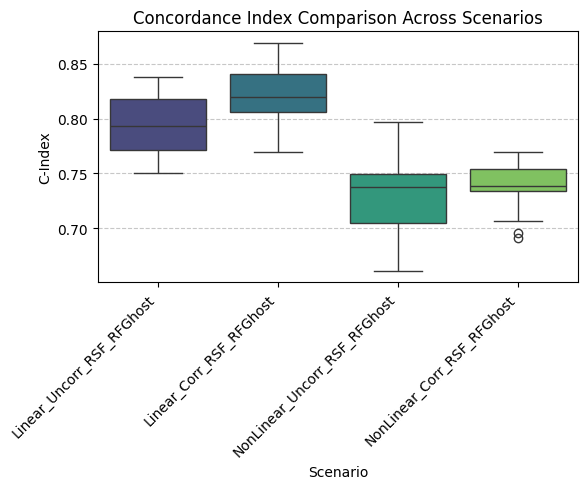

Saved C-Index plot to: simulation1_plots\sim1_cindex_comparison.png

Generating Rank plots (y-axis limit: 5)...
... Rank plot for X1


C:\Users\sanisaza\AppData\Local\Temp\ipykernel_16760\1200113978.py:320: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=var_df, x='scenario_name', y='relevance_rank', jitter=0.2, alpha=0.6, palette='viridis', s=5)


<Figure size 1000x600 with 0 Axes>

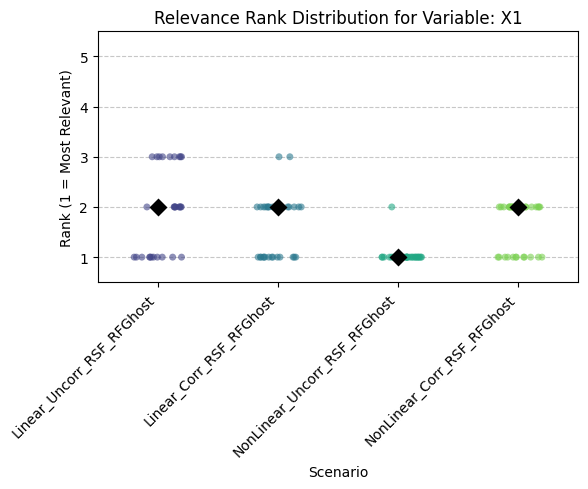

Saved Rank plot for X1 to: simulation1_plots\sim1_rank_comparison_X1.png
... Rank plot for X2


C:\Users\sanisaza\AppData\Local\Temp\ipykernel_16760\1200113978.py:320: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=var_df, x='scenario_name', y='relevance_rank', jitter=0.2, alpha=0.6, palette='viridis', s=5)


<Figure size 1000x600 with 0 Axes>

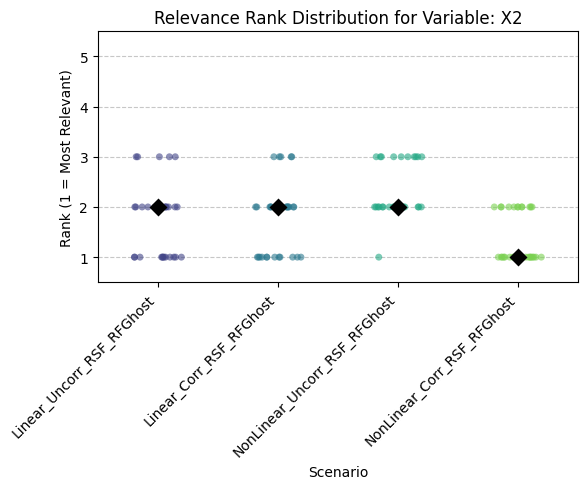

Saved Rank plot for X2 to: simulation1_plots\sim1_rank_comparison_X2.png
... Rank plot for X3


C:\Users\sanisaza\AppData\Local\Temp\ipykernel_16760\1200113978.py:320: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=var_df, x='scenario_name', y='relevance_rank', jitter=0.2, alpha=0.6, palette='viridis', s=5)


<Figure size 1000x600 with 0 Axes>

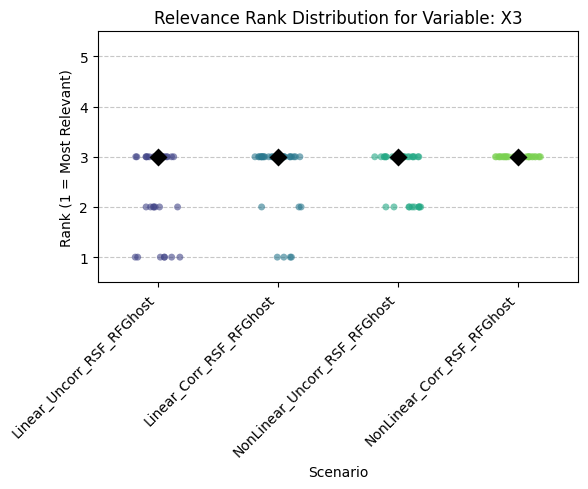

Saved Rank plot for X3 to: simulation1_plots\sim1_rank_comparison_X3.png
... Rank plot for X4


C:\Users\sanisaza\AppData\Local\Temp\ipykernel_16760\1200113978.py:320: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=var_df, x='scenario_name', y='relevance_rank', jitter=0.2, alpha=0.6, palette='viridis', s=5)


<Figure size 1000x600 with 0 Axes>

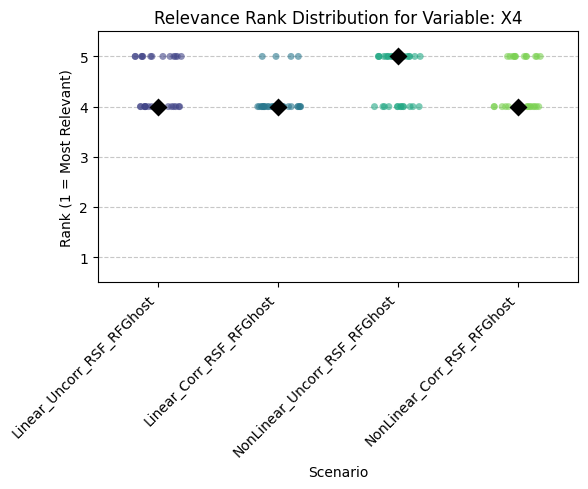

Saved Rank plot for X4 to: simulation1_plots\sim1_rank_comparison_X4.png
... Rank plot for X5


C:\Users\sanisaza\AppData\Local\Temp\ipykernel_16760\1200113978.py:320: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=var_df, x='scenario_name', y='relevance_rank', jitter=0.2, alpha=0.6, palette='viridis', s=5)


<Figure size 1000x600 with 0 Axes>

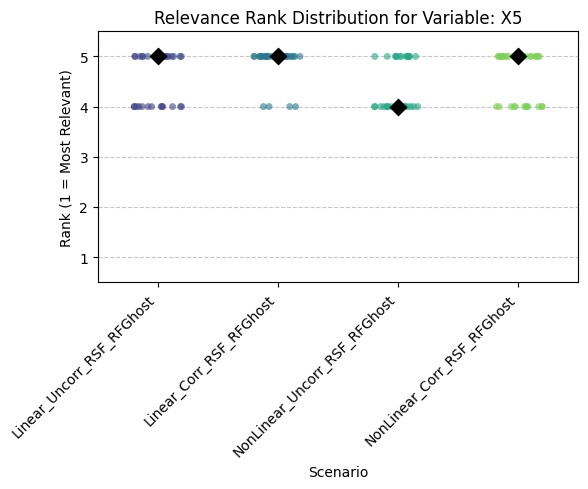

Saved Rank plot for X5 to: simulation1_plots\sim1_rank_comparison_X5.png

Plot generation complete. Check the 'simulation1_plots' directory.


In [41]:
import os

plot_output_dir = 'simulation1_plots'
summary_file = 'experiment1_summary.csv'
# Create the output directory if it doesn't exist
os.makedirs(plot_output_dir, exist_ok=True)

try:
    summary_df = pd.read_csv(summary_file)
    print(f"Successfully loaded summary data from {summary_file}")

    # --- Instantiate ExperimentRunner (just for plotting) ---
    # This requires the ExperimentRunner class to be defined.
    # We get the actual scenario names from the data to pass to the constructor if needed.
    unique_scenario_names = summary_df['scenario_name'].unique()
    dummy_scenarios = [{'name': name} for name in unique_scenario_names]
    runner_for_plotting = ExperimentRunner(scenarios=dummy_scenarios, n_replicates=1)
    print("Initialized ExperimentRunner for plotting.")

    # --- Generate and Save Plots ---

    # 1. C-Index Comparison Plot
    print("Generating C-Index plot...")
    plt.figure(figsize=(10, 6)) # Adjust figure size if needed
    runner_for_plotting.plot_c_index_comparison(summary_df=summary_df)
    cindex_plot_path = os.path.join(plot_output_dir, 'sim1_cindex_comparison.png')
    plt.savefig(cindex_plot_path, bbox_inches='tight')
    plt.close() # Close the plot to prevent display in notebook output
    print(f"Saved C-Index plot to: {cindex_plot_path}")

    # 2. Rank Comparison Plots for key variables
    # Check if needed columns exist before plotting
    if 'variable' in summary_df.columns and 'relevance_rank' in summary_df.columns:
        all_plot_vars = sorted([v for v in summary_df['variable'].unique() if v != 'N/A']) # Get unique valid vars

        # Determine max rank for consistent y-axis limit
        max_rank = summary_df['relevance_rank'].max()
        rank_limit = int(max_rank) if pd.notna(max_rank) else len(all_plot_vars)

        print(f"\nGenerating Rank plots (y-axis limit: {rank_limit})...")
        for var in all_plot_vars:
             print(f"... Rank plot for {var}")
             plt.figure(figsize=(10, 6)) # Adjust figure size
             # Call the plotting function from your ExperimentRunner instance
             runner_for_plotting.plot_rank_comparison(variable=var, summary_df=summary_df, rank_limit=rank_limit)
             rank_plot_path = os.path.join(plot_output_dir, f'sim1_rank_comparison_{var}.png')
             plt.savefig(rank_plot_path, bbox_inches='tight')
             plt.close() # Close the plot
             print(f"Saved Rank plot for {var} to: {rank_plot_path}")
    else:
        print("Warning: 'variable' or 'relevance_rank' columns not found in summary_df. Skipping rank plots.")


    # (Optional) 3. Relevance Score Plots
    # if 'variable' in summary_df.columns and 'relevance_score' in summary_df.columns:
    #      print("\nGenerating Relevance Score plots...")
    #      # Example: only for relevant vars based on your simulation design
    #      relevant_vars_example = ['X1', 'X2', 'X3']
    #      for var in relevant_vars_example:
    #           if var in all_plot_vars: # Check if variable exists
    #                print(f"... Relevance plot for {var}")
    #                plt.figure(figsize=(10, 6))
    #                runner_for_plotting.plot_relevance_comparison(variable=var, summary_df=summary_df)
    #                relevance_plot_path = os.path.join(plot_output_dir, f'sim1_relevance_comparison_{var}.png')
    #                plt.savefig(relevance_plot_path, bbox_inches='tight')
    #                plt.close()
    #                print(f"Saved Relevance Score plot for {var} to: {relevance_plot_path}")
    # else:
    #      print("Warning: 'variable' or 'relevance_score' columns not found in summary_df. Skipping relevance plots.")

    print("\nPlot generation complete. Check the 'simulation1_plots' directory.")

except FileNotFoundError:
    print(f"Error: Summary file not found at {summary_file}")
except NameError as e:
     print(f"ERROR: A required class (like ExperimentRunner) is not defined.")
     print("Please make sure you have executed the cell(s) containing the class definitions in your notebook before running this plotting code.")
     print(f"(Specific error: {e})")
except Exception as e:
    print(f"An error occurred during plot generation: {e}")
    import traceback
    traceback.print_exc()

### REAL DATA

In [44]:
import pandas as pd
import numpy as np

# --- This code requires scikit-survival to be installed ---
try:
    from sksurv.datasets import load_whas500
    from sksurv.util import Surv # To potentially understand the y structure if needed

    # Load the dataset - handle tuple return type
    # This should return a tuple (X, y)
    data_tuple = load_whas500()

    # --- Check if it's a tuple and unpack ---
    if isinstance(data_tuple, tuple) and len(data_tuple) == 2:
        X_real_np, y_real_struct = data_tuple # Unpack the tuple
        # Convert features X (which might be a numpy array) to a pandas DataFrame
        # We need feature names, load_whas500 typically doesn't return them directly this way.
        # We'll use generic names first, and might need to find the real ones.
        n_features = X_real_np.shape[1]
        feature_names = [f'feature_{i+1}' for i in range(n_features)] # Generic names
        X_real = pd.DataFrame(X_real_np, columns=feature_names)
        print("WHAS500 dataset loaded and unpacked successfully.")
    else:
         raise TypeError(f"load_whas500 did not return the expected tuple. Got type: {type(data_tuple)}")

    # Display basic information about features X
    print("\nFeatures (X) Info:")
    print(f"Shape: {X_real.shape}")
    print("\nFirst 5 rows:")
    print(X_real.head().to_string())
    print("\nData Types:")
    print(X_real.dtypes)
    print("\nMissing Values per Column:")
    print(X_real.isnull().sum())

    # Display basic information about the outcome y (structured array)
    print("\nOutcome (y) Info:")
    print(f"Type: {type(y_real_struct)}")
    print(f"Length: {len(y_real_struct)}")
    print(f"dtype names: {y_real_struct.dtype.names}") # Should contain 'fstat' and 'lenfol'

    # Calculate and print event rate
    event_col_name = 'fstat' # Typical name in whas500 for event status (death)
    time_col_name = 'lenfol' # Typical name for time to event/censoring (length of followup)

    if event_col_name in y_real_struct.dtype.names:
        n_events = np.sum(y_real_struct[event_col_name])
        n_total = len(y_real_struct)
        print(f"\nNumber of events ({event_col_name}=True): {n_events} ({n_events/n_total:.1%})")
    else:
        print(f"\nWarning: Could not find the typical event column '{event_col_name}' in y_real_struct.dtype.names")

    if time_col_name not in y_real_struct.dtype.names:
         print(f"\nWarning: Could not find the typical time column '{time_col_name}' in y_real_struct.dtype.names")


except ImportError:
    print("--------------------------------------------------------------------------")
    print("IMPORT ERROR: scikit-survival library not found.")
    print("Please install it using 'pip install scikit-survival' in your environment")
    print("and RESTART the notebook kernel before running this code again.")
    print("--------------------------------------------------------------------------")
except Exception as e:
    print(f"An error occurred while loading or inspecting the whas500 dataset: {e}")
    import traceback
    traceback.print_exc()

WHAS500 dataset loaded and unpacked successfully.

Features (X) Info:
Shape: (500, 14)

First 5 rows:
   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  feature_7  feature_8  feature_9  feature_10  feature_11  feature_12  feature_13  feature_14
0        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN         NaN         NaN         NaN         NaN         NaN
1        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN         NaN         NaN         NaN         NaN         NaN
2        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN         NaN         NaN         NaN         NaN         NaN
3        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN         NaN         NaN         NaN         NaN         NaN
4        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN    

In [46]:
# count null per columns
X_real.isnull().sum()

feature_1     500
feature_2     500
feature_3     500
feature_4     500
feature_5     500
feature_6     500
feature_7     500
feature_8     500
feature_9     500
feature_10    500
feature_11    500
feature_12    500
feature_13    500
feature_14    500
dtype: int64

In [48]:
import pandas as pd
import numpy as np

# --- This code requires scikit-survival version 0.23.1 (or compatible) ---
try:
    from sksurv.datasets import load_whas500
    from sksurv.util import Surv # For checking y structure
    import sklearn # To check the Bunch type if needed

    print(f"Attempting to load whas500 using sksurv...")

    # --- Standard loading for sksurv datasets (no arguments) ---
    whas500_bunch = load_whas500()

    # --- Verify the returned type and access data ---
    print(f"Type returned by load_whas500(): {type(whas500_bunch)}")

    # Check if it looks like a scikit-learn Bunch object or has the needed attributes
    if hasattr(whas500_bunch, 'data') and hasattr(whas500_bunch, 'target'):
        X_real = whas500_bunch.data
        y_real_struct = whas500_bunch.target

        # Ensure X_real is a pandas DataFrame (it should be by default)
        if not isinstance(X_real, pd.DataFrame):
            print("Warning: whas500_bunch.data is not a DataFrame. Attempting conversion.")
            # If it's a numpy array, try to get column names from DESCR or use generic ones
            try:
                if hasattr(whas500_bunch, 'DESCR'):
                     # Basic parsing attempt for feature names from description
                     desc_lines = whas500_bunch.DESCR.split('\\n')
                     feature_names = [line.split(':')[0].strip() for line in desc_lines if ':' in line and not line.strip().startswith("**")]
                     # This parsing is fragile, might need manual adjustment
                     if len(feature_names) == X_real.shape[1]:
                          print("Attempting to use feature names parsed from DESCR.")
                          X_real = pd.DataFrame(X_real, columns=feature_names)
                     else:
                          raise ValueError("Parsed names count doesn't match feature count.")
                else:
                     raise ValueError("No DESCR attribute to parse feature names.")
            except Exception as e:
                 print(f"Could not determine feature names reliably ({e}). Using generic names.")
                 n_features = X_real.shape[1]
                 generic_feature_names = [f'feature_{i+1}' for i in range(n_features)]
                 X_real = pd.DataFrame(X_real, columns=generic_feature_names)

        print("WHAS500 dataset loaded successfully.")

    else:
        # If it doesn't have .data/.target, raise an error explaining the structure is unexpected
        raise AttributeError(f"Returned object from load_whas500() is type {type(whas500_bunch)} "
                             "and does not have the expected '.data' and '.target' attributes.")

    # --- Proceed with Inspection ---
    print("\nFeatures (X) Info:")
    print(f"Shape: {X_real.shape}")
    # It's useful to see column names now if they were loaded correctly
    print(f"Columns: {X_real.columns.tolist()}")
    print("\nFirst 5 rows:")
    print(X_real.head().to_string()) # Use to_string() for better console view
    print("\nData Types:")
    print(X_real.dtypes)
    print("\nMissing Values per Column:")
    missing_counts = X_real.isnull().sum()
    print(missing_counts[missing_counts > 0]) # Only show columns with missing values
    if missing_counts.sum() == 0:
        print("No missing values detected in features.")
    else:
        print(f"Total missing values found: {missing_counts.sum()}")


    print("\nOutcome (y) Info:")
    print(f"Type: {type(y_real_struct)}")
    print(f"Length: {len(y_real_struct)}")
    print(f"dtype names: {y_real_struct.dtype.names}")

    event_col_name = 'fstat'
    time_col_name = 'lenfol'
    if event_col_name in y_real_struct.dtype.names:
        n_events = np.sum(y_real_struct[event_col_name])
        n_total = len(y_real_struct)
        print(f"\nNumber of events ({event_col_name}=True): {n_events} ({n_events/n_total:.1%})")
    else:
        print(f"\nWarning: Could not find the typical event column '{event_col_name}'.")

    if time_col_name not in y_real_struct.dtype.names:
         print(f"\nWarning: Could not find the typical time column '{time_col_name}'.")


except ImportError:
    print("--------------------------------------------------------------------------")
    print("IMPORT ERROR: scikit-survival library not found or failed to import.")
    print("Please ensure it's correctly installed and RESTART the kernel.")
    print("--------------------------------------------------------------------------")
except Exception as e:
    print(f"An error occurred while loading or inspecting the whas500 dataset: {e}")
    import traceback
    traceback.print_exc()

Attempting to load whas500 using sksurv...
Type returned by load_whas500(): <class 'tuple'>
An error occurred while loading or inspecting the whas500 dataset: Returned object from load_whas500() is type <class 'tuple'> and does not have the expected '.data' and '.target' attributes.


Traceback (most recent call last):
  File "C:\Users\sanisaza\AppData\Local\Temp\ipykernel_16760\4035431367.py", line 50, in <module>
    raise AttributeError(f"Returned object from load_whas500() is type {type(whas500_bunch)} "
AttributeError: Returned object from load_whas500() is type <class 'tuple'> and does not have the expected '.data' and '.target' attributes.
